In [36]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

import statsmodels.stats.power as smp
from statsmodels.stats.anova import AnovaRM
from tqdm import tqdm

# reload utils
import importlib
importlib.reload(utils)


from natsort import index_natsorted

# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.family'] = 'Calibri'

path_figs = "./Figs/"

seq_length = 7 #Length of sequences

windowSizes = [1, 2, 3, 7]

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers

iti = 3000   #Inter trial interval
hand = 2 #left or right hand

# total_sub_num = 10
sub_nums = [1,2]

num_trained_seq = 1

total_sub_num = 20
num_sessions = 3
num_blocks_per_session = 4

num_baseline_blocks = 1
num_trials_per_block = 40

percentile_low = 45;	# Lower percentile for ETs
percentile_high = 80;	# Upper percentile for ETs
percentile_low_super = 10;	# Lower percentile for ETs



In [37]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

def set_figure_style(scale="1col"):
    """
    Set figure styling based on publication constraints.
    
    Parameters:
        scale (str): Scale of the figure, choose from "1col", "1.5col", "2col".
                     - "1col" for 8.5cm
                     - "1.5col" for 11.6cm
                     - "2col" for 17.6cm
    """
    # Define width options in cm
    widths = {"1col": 7.62, "1.5col": 11.6, "2col": 16.5}
    
    if scale not in widths:
        raise ValueError("Invalid scale. Choose from '1col', '1.5col', or '2col'.")
    
    # Convert width from cm to inches (1 cm = 0.393701 inches)
    width_in = widths[scale] * 0.393701
    
    # Set figure size (width, height)
    # Assuming height proportional to width (Golden Ratio)
    golden_ratio = (5**0.5 - 1) / 2
    rcParams["figure.figsize"] = (width_in, width_in * golden_ratio)
    
    # Set font sizes
    rcParams["font.size"] = 10  # General font size
    # rcParams["font.size"] = 20  # General font size
    rcParams["axes.titlesize"] = 12  # Figure title
    # rcParams["axes.titlesize"] = 26  # Figure title
    rcParams["axes.labelsize"] = 9  # Axis main label
    # rcParams["axes.labelsize"] = 22  # Axis main label
    rcParams["xtick.labelsize"] = 7  # Tick labels
    # rcParams["xtick.labelsize"] = 16  # Tick labels
    rcParams["ytick.labelsize"] = 7
    # rcParams["ytick.labelsize"] = 16
    rcParams["legend.fontsize"] = 8  # Legend entries
    # rcParams["legend.fontsize"] = 20  # Legend entries
    rcParams["figure.titleweight"] = "bold"
    
    # Set stroke width
    rcParams["axes.linewidth"] = 0.75
    # rcParams["axes.linewidth"] = 1.5

    # rcParams["lines.linewidth"] = 3
    
    rcParams["xtick.major.width"] = 0.75
    # rcParams["xtick.major.width"] = 1.5
    rcParams["ytick.major.width"] = 0.75
    # rcParams["ytick.major.width"] = 1.5

    
    # Subpanel lettering size
    rcParams["text.usetex"] = False  # Set to True if using LaTeX
    rcParams["axes.formatter.use_mathtext"] = True  # Math text for scientific notation

def add_subpanel_label(ax, label, fontsize=20, position=(-0.1, 1.05)):
    """
    Add a subpanel label (e.g., 'a', 'b') to a subplot.
    
    Parameters:
        ax (Axes): Matplotlib Axes object.
        label (str): The label text.
        fontsize (int): Font size for the label.
        position (tuple): Position of the label in axes coordinates.
    """
    ax.text(position[0], position[1], label, transform=ax.transAxes, 
            fontsize=fontsize, fontweight="bold", va="top", ha="left")

###
set_figure_style(scale="1col")

sns.set_palette("colorblind")


In [41]:
subjs = pd.read_csv(utils.path_misc+'subjs.csv', sep = '\t')

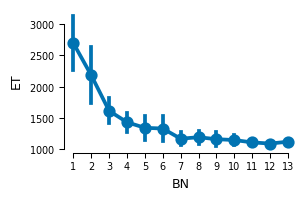

In [42]:
subjs_correct = utils.remove_error_trials(subjs) ###Removing error trials
subjs_grouped = subjs_correct.groupby(['SubNum', 'BN']).agg({
    'ET': 'median'
}).reset_index()
sns.pointplot(data = subjs_grouped, x = 'BN', y = 'ET')
sns.despine(trim = True)


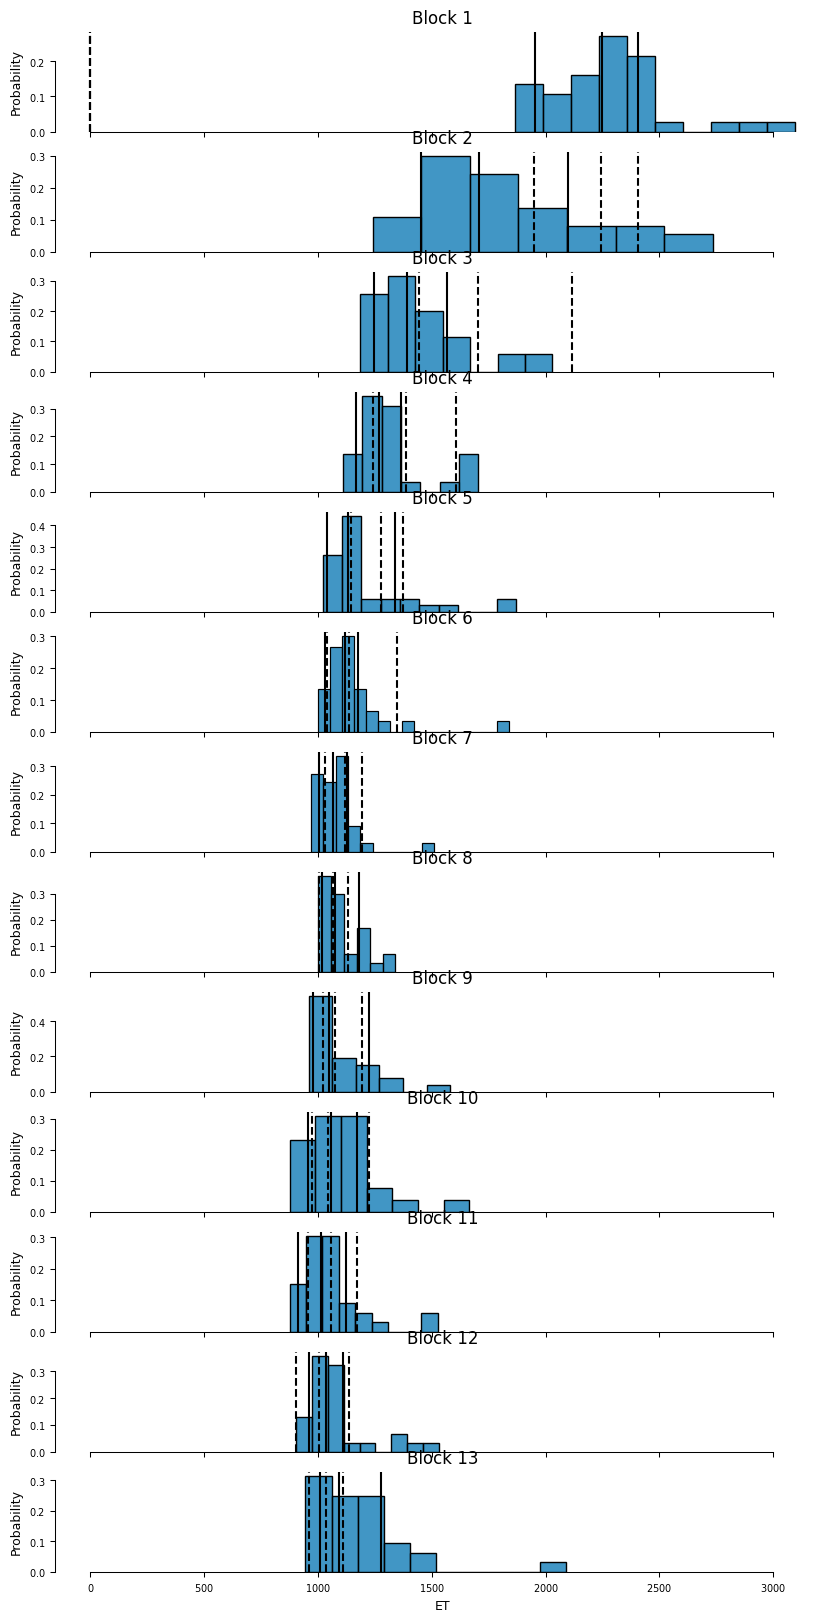

In [45]:
fig, axs = plt.subplots(len(subjs['BN'].unique()),1, figsize=(10, 20), sharex=True)
selected_sub = subjs[subjs['SubNum'] == 2] ###Selecting one subject

selected_sub = utils.remove_error_trials(selected_sub) ###Removing error trials for the selected subject
for bn, block_data in selected_sub.groupby('BN'):
    sns.histplot(data = block_data, x = 'ET', ax = axs[bn-1], stat = 'probability')
    axs[bn-1].axvline(block_data['estimatedPercentileHigh'].values[0], linestyle = '--', color = 'black')
    axs[bn-1].axvline(block_data['estimatedPercentileLow'].values[0], linestyle = '--', color = 'black')
    axs[bn-1].axvline(block_data['estimatedPercentileLowSuper'].values[0],linestyle = '--', color = 'black')

    axs[bn-1].axvline(np.percentile(block_data['ET'], percentile_low_super), linestyle = '-', color = 'black')
    axs[bn-1].axvline(np.percentile(block_data['ET'], percentile_low), linestyle = '-', color = 'black')
    axs[bn-1].axvline(np.percentile(block_data['ET'], percentile_high), linestyle = '-', color = 'black')

    axs[bn-1].set_title(f'Block {bn}')

sns.despine(trim = True)

# Force Analysis

In [127]:
subjs = pd.read_csv(utils.path_misc+'subjs.csv', sep = '\t')

In [128]:
# exclude first block 
subjs = subjs[subjs['BN'] > 1]
rank_df = pd.DataFrame(index = subjs.index)
for subnum, data in subjs.groupby('SubNum'):
    data = data.sort_values(by = ['BN', 'TN'])
    data['N'] = data.groupby(['BN', 'TN']).ngroup() + 1
    rank_df.loc[data.index, 'N'] = data['N'].astype('int')
        

subjs['N'] = rank_df['N'].astype('int')
subjs = subjs[subjs['isCross'] == 0]

In [129]:

processed_forces = pd.read_csv(utils.path_misc+'processed_forces.csv', sep = '\t')
# convert force_vector to numpy array
processed_forces['force_vector'] = processed_forces['force_vector'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))


In [130]:
processed_forces.columns

Index(['SubNum', 'BN', 'TN', 'points', 'zone', 'isError', 'RT', 'ET', 'N',
       'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9',
       'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16',
       'force_vector', 'day', 'day_change', 'block_change'],
      dtype='object')

In [131]:
subdata[subdata['day_change'] == 1]

,SubNum,BN,TN,points,zone,isError,RT,ET,N,PC_1,...,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,force_vector,day,day_change,block_change
479,2,2,1,0,4,0,1140,2735,1,-61.865580,...,2.458447,0.982562,-5.047910,-1.492643,-2.863412,-2.380707,"[-61.86557992, 7.20819098, -12.85625575, 14.71...",1,1,1
639,2,6,1,0,4,0,545,1840,161,-49.033534,...,0.657540,3.158559,-4.893992,-2.378236,-1.471857,-4.011647,"[-49.03353379, -0.36972442, -10.95828327, 11.3...",2,1,1
798,2,10,1,0,4,0,325,1355,321,-8.859459,...,2.418481,-9.143449,-2.081381,1.348804,-0.941814,6.173442,"[-8.85945851, -13.99330118, -19.97031004, -2.2...",3,1,1


100%|██████████| 2/2 [00:00<00:00,  4.36it/s]


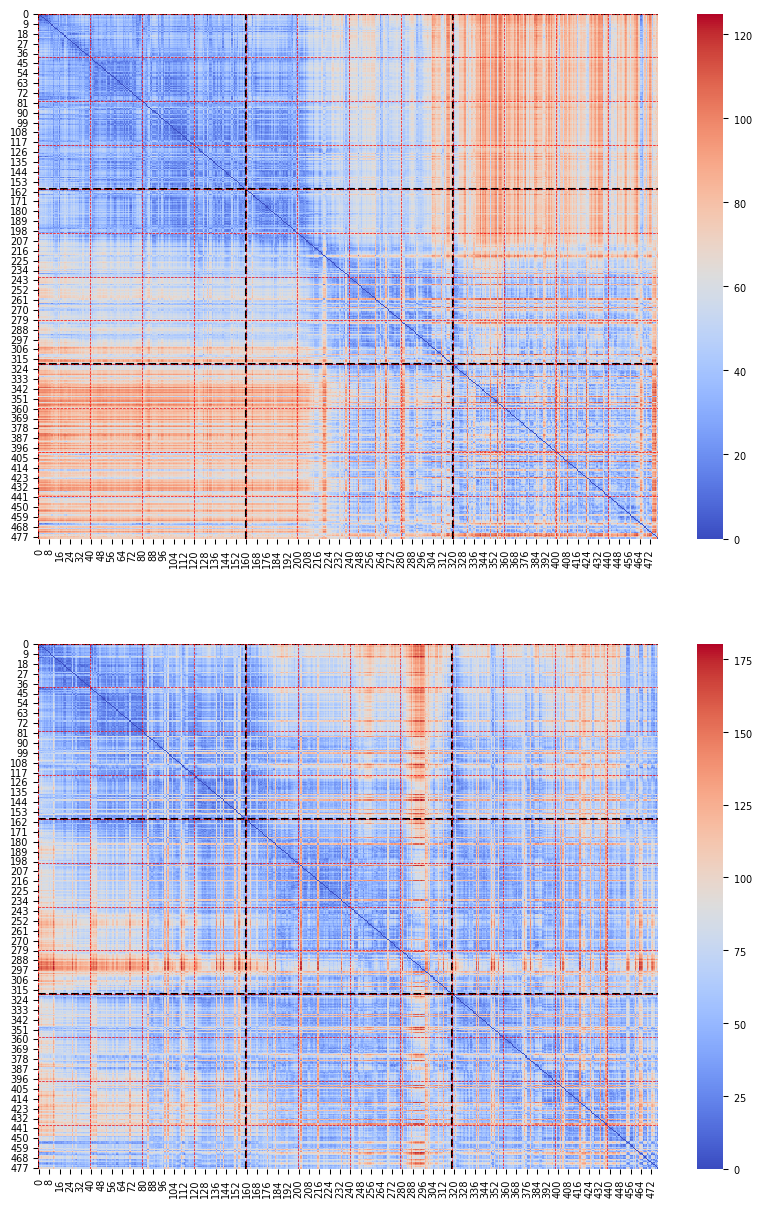

In [132]:
n_subjs = len(processed_forces['SubNum'].unique())
fig, axs = plt.subplots(n_subjs, figsize=(10, 15))
for subind, subdata in tqdm(processed_forces.groupby('SubNum')):
    # compute euclidean distance of all force vectors from each other
    force_vectors = subdata[[f'PC_{i+1}' for i in range(n_dims)]].to_numpy()
    euclidean_distances = np.linalg.norm(force_vectors[:, np.newaxis] - force_vectors, axis=2)


    sns.heatmap(euclidean_distances, cmap='coolwarm', annot=False, cbar=True, ax=axs[subind-1])

    # plotting day changes on the heatmap
    day_changes = subdata['day_change'].values
    for i in range(len(day_changes)):
        if day_changes[i] == 1:
            axs[subind-1].axvline(i, color='black', linestyle='--')
            axs[subind-1].axhline(i, color='black', linestyle='--')

    # plotting block changes on the heatmap
    block_changes = subdata['block_change'].values
    for i in range(len(block_changes)):
        if block_changes[i] == 1:
            axs[subind-1].axvline(i, color='red', linestyle='--', linewidth=0.5)
            axs[subind-1].axhline(i, color='red', linestyle='--',  linewidth=0.5)


    
    
    


    

# Modulation of Distance based on Reward

In [133]:
distances = []
for subind, subdata in processed_forces.groupby('SubNum'):
    zone_two_data = subdata[subdata['zone'] == 2]
    for point, pointdata in zone_two_data.groupby('points'):
        # loop through all the points in the pointdata
        for i in range(len(pointdata)):
            row = pointdata.iloc[i]
            N = row['N']
            next_trial = subdata[subdata['N'] == N + 1]
            if not next_trial.empty:
                next_row = next_trial.iloc[0]
                # compute the euclidean distance between the force vectors of the two trials
                force_vector_1 = row['force_vector']
                force_vector_2 = next_row['force_vector']
                euclidean_distance = np.linalg.norm(force_vector_1 - force_vector_2)
                distances.append({
                    'SubNum': subind,
                    'points': point,
                    'zone': row['zone'],
                    'distance': euclidean_distance
                })

    zone_three_data = subdata[subdata['zone'] == 3]
    for point, pointdata in zone_three_data.groupby('points'):
        # loop through all the points in the pointdata
        for i in range(len(pointdata)):
            row = pointdata.iloc[i]
            N = row['N']
            next_trial = subdata[subdata['N'] == N + 1]
            if not next_trial.empty:
                next_row = next_trial.iloc[0]
                # compute the euclidean distance between the force vectors of the two trials
                force_vector_1 = row['force_vector']
                force_vector_2 = next_row['force_vector']
                euclidean_distance = np.linalg.norm(force_vector_1 - force_vector_2)
                distances.append({
                    'SubNum': subind,
                    'points': point,
                    'zone': row['zone'],
                    'distance': euclidean_distance
                })
        

distances = pd.DataFrame(distances)
        
distances['count'] = 1

In [134]:
# calculate number of points in each zone for each subject
zone_counts = processed_forces.groupby(['SubNum', 'zone']).size().reset_index(name='count')
zone_counts

,SubNum,zone,count
0,1,0,72
1,1,1,136
2,1,2,114
3,1,3,67
4,1,4,90
5,2,0,102
6,2,1,106
7,2,2,113
8,2,3,94
9,2,4,63


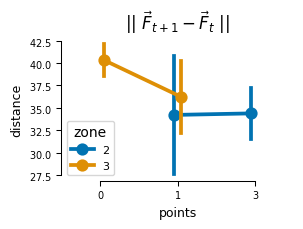

In [135]:
grouped_distances = distances.groupby(['SubNum', 'points', 'zone']).agg({'distance': 'mean',
                                                                         'count': 'count'}).reset_index()
grouped_distances

sns.pointplot(data=grouped_distances, x='points', y='distance', hue='zone', palette='colorblind', dodge=0.1, errorbar='se')
sns.despine(trim=True)
plt.title(r'|| $\vec{F}_{t+1} - \vec{F}_{t}$ ||')
plt.show()

# Modulation of cos angel on innovation based on Reward

In [136]:
cosines = []
for subind, subdata in processed_forces.groupby('SubNum'):
    zone_two_data = subdata[subdata['zone'] == 2]
    for point, pointdata in zone_two_data.groupby('points'):
        # loop through all the points in the pointdata
        for i in range(len(pointdata)):
            row = pointdata.iloc[i]
            N = row['N']
            next_trial = subdata[subdata['N'] == N + 1]
            prev_trial = subdata[subdata['N'] == N - 1]
            if not next_trial.empty and not prev_trial.empty:
                next_row = next_trial.iloc[0]
                prev_row = prev_trial.iloc[0]
                # compute cosine similarity between difference
                force_vector_1 = row['force_vector']
                force_vector_2 = next_row['force_vector']
                force_vector_3 = prev_row['force_vector']
                cosine_similarity = np.dot(force_vector_1 - force_vector_3, force_vector_2 - force_vector_1)/ \
                (np.linalg.norm(force_vector_1 - force_vector_3) * np.linalg.norm(force_vector_2 - force_vector_1)) 
                cosines.append({
                    'SubNum': subind,
                    'points': point,
                    'zone': row['zone'],
                    'cosine_similarity': cosine_similarity
                })



    zone_three_data = subdata[subdata['zone'] == 3]
    for point, pointdata in zone_three_data.groupby('points'):
        # loop through all the points in the pointdata
        for i in range(len(pointdata)):
            row = pointdata.iloc[i]
            N = row['N']
            next_trial = subdata[subdata['N'] == N + 1]
            prev_trial = subdata[subdata['N'] == N - 1]
            if not next_trial.empty and not prev_trial.empty:
                next_row = next_trial.iloc[0]
                prev_row = prev_trial.iloc[0]
                # compute cosine similarity between difference
                force_vector_1 = row['force_vector']
                force_vector_2 = next_row['force_vector']
                force_vector_3 = prev_row['force_vector']
                cosine_similarity = np.dot(force_vector_1 - force_vector_3, force_vector_2 - force_vector_1)/ \
                (np.linalg.norm(force_vector_1 - force_vector_3) * np.linalg.norm(force_vector_2 - force_vector_1)) 
                cosines.append({
                    'SubNum': subind,
                    'points': point,
                    'zone': row['zone'],
                    'cosine_similarity': cosine_similarity
                })
        

cosines = pd.DataFrame(cosines)
        
cosines['count'] = 1

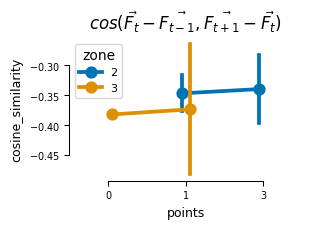

In [140]:
grouped_cosines = cosines.groupby(['SubNum', 'points', 'zone']).agg({'cosine_similarity': 'mean',
                                                                         'count': 'count'}).reset_index()
grouped_cosines

sns.pointplot(data=grouped_cosines, x='points', y='cosine_similarity', hue='zone', palette='colorblind', dodge=0.1, errorbar='se')
sns.despine(trim=True)
plt.title(r'$cos (\vec{F_t} - \vec{F_{t-1}}, \vec{F_{t+1}} - \vec{F_t})$')
plt.show()



# Modulation of cos angel based on Reward

In [141]:
cosines = []
for subind, subdata in processed_forces.groupby('SubNum'):
    zone_two_data = subdata[subdata['zone'] == 2]
    for point, pointdata in zone_two_data.groupby('points'):
        # loop through all the points in the pointdata
        for i in range(len(pointdata)):
            row = pointdata.iloc[i]
            N = row['N']
            next_trial = subdata[subdata['N'] == N + 1]
            if not next_trial.empty:
                next_row = next_trial.iloc[0]
                # compute cosine similarity 
                force_vector_1 = row['force_vector']
                force_vector_2 = next_row['force_vector']
                cosine_similarity = np.dot(force_vector_1, force_vector_2) / \
                (np.linalg.norm(force_vector_1) * np.linalg.norm(force_vector_2))
                # append to the cosines list
                cosines.append({
                    'SubNum': subind,
                    'points': point,
                    'zone': row['zone'],
                    'cosine_similarity': cosine_similarity
                })



    zone_three_data = subdata[subdata['zone'] == 3]
    for point, pointdata in zone_three_data.groupby('points'):
        # loop through all the points in the pointdata
        for i in range(len(pointdata)):
            row = pointdata.iloc[i]
            N = row['N']
            next_trial = subdata[subdata['N'] == N + 1]
            if not next_trial.empty:
                next_row = next_trial.iloc[0]
                # compute cosine similarity 
                force_vector_1 = row['force_vector']
                force_vector_2 = next_row['force_vector']
                cosine_similarity = np.dot(force_vector_1, force_vector_2) / \
                (np.linalg.norm(force_vector_1) * np.linalg.norm(force_vector_2))
                # append to the cosines list
                cosines.append({
                    'SubNum': subind,
                    'points': point,
                    'zone': row['zone'],
                    'cosine_similarity': cosine_similarity
                })
        

cosines = pd.DataFrame(cosines)
        
cosines['count'] = 1

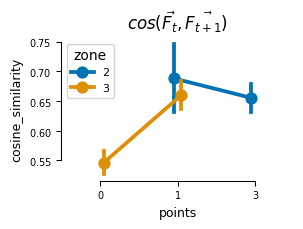

In [142]:
grouped_cosines = cosines.groupby(['SubNum', 'points', 'zone']).agg({'cosine_similarity': 'mean',
                                                                         'count': 'count'}).reset_index()
grouped_cosines

sns.pointplot(data=grouped_cosines, x='points', y='cosine_similarity', hue='zone', palette='colorblind', dodge=0.1, errorbar='se')
sns.despine(trim=True)
plt.title(r'$cos (\vec{F_t}, \vec{F_{t+1}})$')
plt.show()

